<a href="https://colab.research.google.com/github/rahiakela/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/blob/15-processing-sequences-using-RNNs-CNNs/2_forecasting_time_series_handling_long_sequences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handling Long Sequences

To train an RNN on long sequences, we must run it over many time steps, making the unrolled RNN a very deep network. Just like any deep neural network it may suffer from the unstable gradients problem, It may take forever to train, or training may be unstable. Moreover, when an RNN processes a long sequence, it will gradually forget the first inputs in the sequence.

## Setup

In [2]:
import sys
assert sys.version_info >= (3, 5)  # Python ≥3.5 is required

import sklearn 
assert sklearn.__version__ >= "0.20"  # Scikit-Learn ≥0.20 is required

# %tensorflow_version only exists in Colab.
try:
  %tensorflow_version 2.x
  IS_COLAB = True
except Exception:
  IS_COLAB = False
  pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= '2.0'

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

TensorFlow 2.x selected.


## Generate the Dataset

For simplicity, we are using a time series generated by the generate_time_series() function.

In [0]:
def generate_time_series(batch_size, n_steps):
  freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
  time = np.linspace(0, 1, n_steps)

  series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))      # wave 1
  series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))     # + wave 2
  series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)       # + noise

  return series[..., np.newaxis].astype(np.float32)

This function creates as many time series as requested (via the batch_size argument), each of length n_steps , and there is just one value per time step in each series (i.e., all series are univariate). The function returns a NumPy array of shape [ batch size , time steps , 1], where each series is the sum of two sine waves of fixed amplitudes but random frequencies and phases, plus a bit of noise.

When dealing with time series (and other types of sequences such as sentences), the input features are generally represented as 3D arrays of shape [ batch size , time steps , dimensionality ], where dimensionality is 1 for univariate time series and more for multivariate time series.

Now let’s create a training set, a validation set, and a test set.

In [0]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)

X_train, y_train = series[:7000, : n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, n_steps], series[9000:, -1]

In [5]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Since we want to forecast a single value for each series, the targets are column vectors (e.g., y_train has a shape of [7000, 1]).

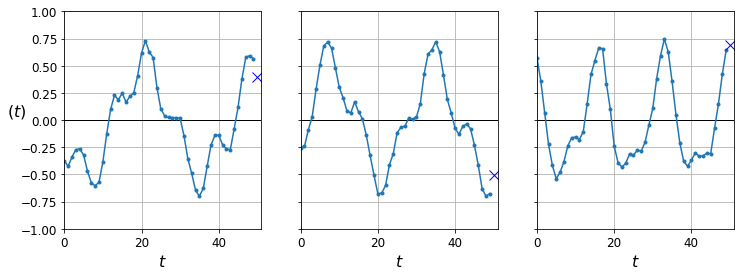

In [6]:
def plot_series(series, y=None, y_pred=None, x_label='$t$', y_label='$x(t)$'):
  plt.plot(series, '.-')

  if y is not None:
    plt.plot(n_steps, y, 'bx', markersize=10)
  if y_pred is not None:
    plt.plot(n_steps, y_pred , 'ro')
  plt.grid(True)

  if x_label:
    plt.xlabel(x_label, fontsize=16)
  if y_label:
    plt.ylabel(y_label, fontsize=16, rotation=0)

  plt.hlines(0, 0, 100, linewidth=1)
  plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
  plt.sca(axes[col])
  plot_series(X_valid[col, :, 0], y_valid[col, 0], y_label=('$(t)$' if col==0 else None))

plt.show()

In [0]:
def plot_multiple_forecasts(X, Y, Y_pred):
  n_steps = X.shape[1]
  ahead = Y.shape[1]
  plot_series(X[0, :, 0])
  plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], 'ro-', label='Actual')
  plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], 'bx-', label='Forecast', markersize=10)
  plt.axis([0, n_steps + ahead, -1, 1])
  plt.legend(fontsize=14)

## Baseline Metrics

Before we start using RNNs, it is often a good idea to have a few baseline metrics, or else we may end up thinking our model works great when in fact it is doing worse than basic models.

For example, the simplest approach is to predict the last value in each series. This is called naive forecasting , and it is sometimes surprisingly difficult to outperform. In this case, it gives us a mean squared error of about 0.020:

In [7]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_absolute_error(y_valid, y_pred))

0.11627829

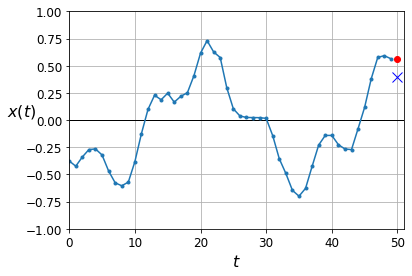

In [8]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Another simple approach is to use a fully connected network. Since it expects a flat list of features for each input, we need to add a Flatten layer. 

Let’s just use a simple Linear Regression model so that each prediction will be a linear combination of the values in the time series:

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)                           
])

model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 1s 179us/sample - loss: 0.1004 - val_loss: 0.0559
Epoch 2/20
7000/7000 [==============================] - 1s 90us/sample - loss: 0.0386 - val_loss: 0.0269
Epoch 3/20
7000/7000 [==============================] - 1s 88us/sample - loss: 0.0205 - val_loss: 0.0162
Epoch 4/20
7000/7000 [==============================] - 1s 89us/sample - loss: 0.0133 - val_loss: 0.0118
Epoch 5/20
7000/7000 [==============================] - 1s 88us/sample - loss: 0.0104 - val_loss: 0.0098
Epoch 6/20
7000/7000 [==============================] - 1s 96us/sample - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
7000/7000 [==============================] - 1s 92us/sample - loss: 0.0080 - val_loss: 0.0078
Epoch 8/20
7000/7000 [==============================] - 1s 88us/sample - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
7000/7000 [==============================] - 1s 87us/sample - loss: 0.0066 - val_loss: 0.0065
Epoch 

In [10]:
model.evaluate(X_valid, y_valid, verbose=0)

0.004145486194640398

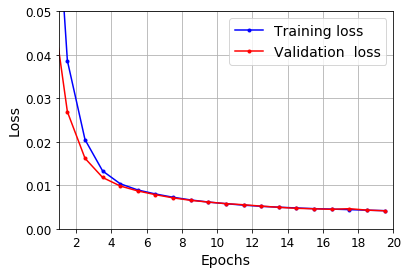

In [11]:
def plot_learning_curves(loss, val_loss):
  plt.plot(np.arange(len(loss)) + 0.5, loss, 'b.-', label='Training loss')
  plt.plot(np.arange(len(val_loss)) + 0.5, val_loss, 'r.-', label='Validation  loss')

  plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
  plt.axis([1, 20, 0, 0.05])
  plt.legend(fontsize=14)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.grid(True)

plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

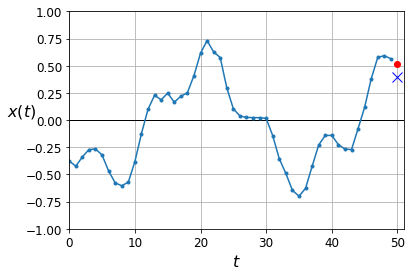

In [12]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

we get an MSE of about 0.004. That’s much better than the naive approach!

## Fighting the Unstable Gradients Problem

Many of the tricks we used in deep nets to alleviate the unstable gradients problem can also be used for RNNs: good parameter initialization, faster optimizers, dropout, and so on. However, nonsaturating activation functions (e.g., ReLU) may not help as much here; in fact, they may actually lead the RNN to be even more unstable during training.

Why? Well, suppose Gradient Descent updates the weights in a way that increases the outputs slightly at the first time step. Because the same weights are used at every time step, the outputs at the second time step may also be slightly increased, and those at the third, and so on until the outputs explode—and a nonsaturating activation function does not prevent that. You can reduce this risk by using a smaller learning rate, but you can also simply use a saturating activation function like the hyperbolic tangent (this explains why it is the default). In much the same way, the gradients themselves can explode.

In [0]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))

for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
    
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [14]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

## Deep RNN with Batch Norm


Moreover, Batch Normalization cannot be used as efficiently with RNNs as with deep feedforward nets. In fact, you cannot use it between time steps, only between recurrent layers. To be more precise, it is technically possible to add a BN layer to a memory cell so that it will be applied at each time step (both on the inputs for that time step and on the hidden state from the previous step).

However, the same BN layer will be used at each time step, with the same parameters, regardless of the actual scale and offset of the inputs and hidden state.

In Keras this can be done simply by adding a BatchNormalization layer before each recurrent layer, but don’t expect too much from it.



In [15]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
   keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
   keras.layers.BatchNormalization(),
   keras.layers.SimpleRNN(20, return_sequences=True),
   keras.layers.BatchNormalization(),
   keras.layers.TimeDistributed(keras.layers.Dense(10))                              
])

def last_time_step_mse(Y_true, Y_pred):
  return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])
  
model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])

history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 17s 2ms/sample - loss: 0.1936 - last_time_step_mse: 0.1913 - val_loss: 0.0901 - val_last_time_step_mse: 0.0863
Epoch 2/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0531 - last_time_step_mse: 0.0441 - val_loss: 0.0559 - val_last_time_step_mse: 0.0469
Epoch 3/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0470 - last_time_step_mse: 0.0374 - val_loss: 0.0453 - val_last_time_step_mse: 0.0354
Epoch 4/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0437 - last_time_step_mse: 0.0337 - val_loss: 0.0423 - val_last_time_step_mse: 0.0320
Epoch 5/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0414 - last_time_step_mse: 0.0310 - val_loss: 0.0402 - val_last_time_step_mse: 0.0301
Epoch 6/20
7000/7000 [==============================] - 16s 2ms/sample - loss: 0.0390 - last_time_step_mse: 0.0283 - 

In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

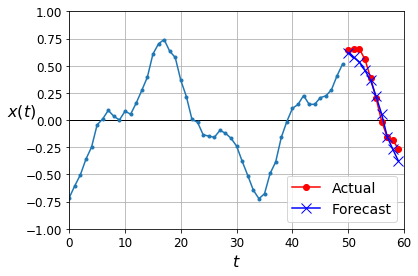

In [21]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Deep RNNs with Layer Norm

Another form of normalization often works better with RNNs: Layer Normalization.it is very similar to Batch Normalization, but instead of normalizing across the batch dimension, it normalizes across the features dimension. One advantage is that it can compute the required statistics on the fly, at each time step, independently for each instance. This also means that it behaves the same way during training and testing (as opposed to BN), and it does not need to use exponential moving averages to estimate the feature statistics across all instances in the training set. 

Like BN, Layer Normalization learns a scale and an offset parameter for each input. In an RNN, it is typically used right after the linear combination of the inputs and the hidden states.

Let’s use tf.keras to implement Layer Normalization within a simple memory cell. For this, we need to define a custom memory cell. It is just like a regular layer, except its call() method takes two arguments: the inputs at the current time step and the hidden states from the previous time step. Note that the states argument is a list containing one or more tensors. 

In the case of a simple RNN cell it contains a single tensor equal to the outputs of the previous time step, but other cells may have multiple state tensors (e.g., an LSTMCell has a long-term state and a short-term state, as we will see shortly). A cell must also have a state_size attribute and an output_size attribute. In a simple RNN, both are simply equal to the number of units.

In [0]:
from tensorflow.keras.layers import LayerNormalization

In [0]:
class LNSimpleRNNCell(keras.layers.Layer):

  def __init__(self, units, activation='tanh', **kwargs):
    super().__init__(**kwargs)
    self.state_size = units
    self.output_size = units
    self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
    self.layer_norm = LayerNormalization()
    self.activation = keras.activations.get(activation)

  def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
    if inputs is not None:
      batch_size = tf.shape(inputs)[0]
      dtype = inputs.dtype
    return [tf.zeros([batch_size, self.state_size], dtype=dtype)]

  def call(self, inputs, states):
    outputs, new_states = self.simple_rnn_cell(inputs, states)
    norm_outputs = self.activation(self.layer_norm(outputs))
    return norm_outputs, [norm_outputs]

Our LNSimpleRNNCell class inherits from the keras.layers.Layer class, just like any custom layer. The constructor takes the number of units and the desired activation function, and it sets the state_size and output_size attributes, then creates a SimpleRNNCell with no activation function (because we want to perform Layer Normalization after the linear operation but before the activation function). Then the constructor creates the LayerNormalization layer, and finally it fetches the desired activation function. The call() method starts by applying the simple RNN cell, which computes a linear combination of the current inputs and the previous hidden states, and it returns the result twice (indeed, in a SimpleRNNCell , the outputs are just equal to the hidden states: in other words, new_states[0] is equal to outputs , so we can safely ignore new_states in the rest of the call() method).

To use this custom cell, all we need to do is create a keras.layers.RNN layer, passing it a cell instance:

In [27]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])

history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 28s 4ms/sample - loss: 0.1570 - last_time_step_mse: 0.1502 - val_loss: 0.0716 - val_last_time_step_mse: 0.0662
Epoch 2/20
7000/7000 [==============================] - 22s 3ms/sample - loss: 0.0629 - last_time_step_mse: 0.0560 - val_loss: 0.0563 - val_last_time_step_mse: 0.0493
Epoch 3/20
7000/7000 [==============================] - 22s 3ms/sample - loss: 0.0537 - last_time_step_mse: 0.0463 - val_loss: 0.0503 - val_last_time_step_mse: 0.0429
Epoch 4/20
7000/7000 [==============================] - 21s 3ms/sample - loss: 0.0483 - last_time_step_mse: 0.0404 - val_loss: 0.0447 - val_last_time_step_mse: 0.0364
Epoch 5/20
7000/7000 [==============================] - 21s 3ms/sample - loss: 0.0418 - last_time_step_mse: 0.0319 - val_loss: 0.0390 - val_last_time_step_mse: 0.0281
Epoch 6/20
7000/7000 [==============================] - 21s 3ms/sample - loss: 0.0384 - last_time_step_mse: 0.0275 - 

In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

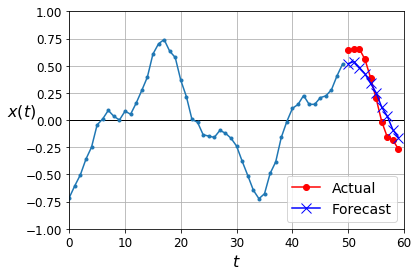

In [29]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Creating a Custom RNN Class

Similarly, you could create a custom cell to apply dropout between each time step. But there’s a simpler way: all recurrent layers (except for keras.layers.RNN ) and all cells provided by Keras have a dropout hyperparameter and a recurrent_dropout hyperparameter: the former defines the dropout rate to apply to the inputs (at each time step), and the latter defines the dropout rate for the hidden states (also at each time step). No need to create a custom cell to apply dropout at each time step in an RNN.

With these techniques, you can alleviate the unstable gradients problem and train an RNN much more efficiently.

In [0]:
class CustomRNN(keras.layers.Layer):

  def __init__(self, cell, return_sequences=False, **kwargs):
    super().__init__(**kwargs)
    self.cell = cell
    self.return_sequences = return_sequences 
    self.get_initial_state = getattr(self.cell, 'get_initial_state', self.fallback_initial_state)

  def fallback_initial_state(self, inputs):
    return [tf.zeros([self.cell.state_size], dtype=inputs.dtype)]

  @tf.function
  def call(self, inputs):
    states = self.get_initial_state(inputs)
    n_steps = tf.shape(inputs)[1]

    if self.return_sequences:
      sequences = tf.TensorArray(inputs.dtype, size=n_steps)
    outputs = tf.zeros(shape=[n_steps, self.cell.output_size], dtype=inputs.dtype)

    for step in tf.range(n_steps):
      outputs, states = self.cell(inputs[:, step], states)
      if self.return_sequences:
        sequences = sequences.write(step, outputs)
    if self.return_sequences:
      return sequences.stack()
    else:
      return outputs

In [34]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    CustomRNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
    CustomRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))                           
])

model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])

history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 26s 4ms/sample - loss: 0.2169 - last_time_step_mse: 0.2020 - val_loss: 0.0879 - val_last_time_step_mse: 0.0764
Epoch 2/20
7000/7000 [==============================] - 23s 3ms/sample - loss: 0.0728 - last_time_step_mse: 0.0607 - val_loss: 0.0630 - val_last_time_step_mse: 0.0510
Epoch 3/20
7000/7000 [==============================] - 24s 3ms/sample - loss: 0.0574 - last_time_step_mse: 0.0435 - val_loss: 0.0530 - val_last_time_step_mse: 0.0384
Epoch 4/20
7000/7000 [==============================] - 24s 3ms/sample - loss: 0.0501 - last_time_step_mse: 0.0356 - val_loss: 0.0483 - val_last_time_step_mse: 0.0319
Epoch 5/20
7000/7000 [==============================] - 24s 3ms/sample - loss: 0.0460 - last_time_step_mse: 0.0317 - val_loss: 0.0442 - val_last_time_step_mse: 0.0297
Epoch 6/20
7000/7000 [==============================] - 24s 3ms/sample - loss: 0.0429 - last_time_step_mse: 0.0288 - 

In [0]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

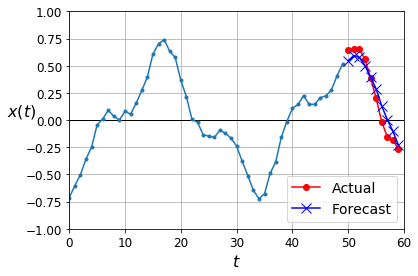

In [36]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()